
# Text-to-Speech with Tacotron2

**Author**: [Yao-Yuan Yang](https://github.com/yangarbiter)_,
[Moto Hira](moto@meta.com)_


## Overview

텍스트 전처리: 먼저 입력 텍스트를 심볼의 목록으로 인코딩합니다. 이 튜토리얼에서는 영어 문자들과 음소를 심볼로 사용합니다.

 스펙트로그램 생성: 인코딩된 텍스트로부터 스펙트로그램을 생성합니다. 이 작업에 Tacotron2 모델을 사용합니다.

 시간 도메인 변환: 마지막 단계는 스펙트로그램을 음성 파형으로 변환하는 것입니다. 스펙트로그램으로부터 음성을 생성하는 과정을 보코더(Vocoder)라고 부릅니다. 이 튜토리얼에서는 WaveRNN, GriffinLim, Nvidia의 WaveGlow 등의 세가지 다른 보코더를 사용합니다.

The following figure illustrates the whole process.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/tacotron2_tts_pipeline.png">

All the related components are bundled in :py:class:`torchaudio.pipelines.Tacotron2TTSBundle`,
but this tutorial will also cover the process under the hood.



## Preparation

First, we install the necessary dependencies. In addition to
``torchaudio``, ``DeepPhonemizer`` is required to perform phoneme-based
encoding.




In [1]:
# %%bash
# pip3 install deep_phonemizer

In [2]:
# !pip3 install torch torchvision torchaudio

In [3]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.3.0+cu121
2.3.0+cu121
cuda


In [4]:
import IPython
import matplotlib.pyplot as plt

## Text Processing




문자 기반 인코딩

이번 섹션에서는 문자 기반 인코딩이 어떻게 동작하는지 알아보겠습니다.

사전 학습된 Tacotron2 모델은 특정한 심볼 테이블 세트를 필요로 하기 때문에, torchaudio에서 제공하는 기능을 그대로 사용할 수 있습니다. 이 섹션은 인코딩이 어떻게 동작하는지 그 기본 원리를 설명하기 위한 것입니다.

먼저 심볼 세트를 설정합니다. 예를 들어,  '_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz' 와 같은 알파벳을 사용할 수 있습니다. 그리고 각 입력 텍스트 문자를 테이블 내 해당 심볼의 인덱스로 변환합니다.

아래는 이러한 과정을 보여주는 예시입니다. 이 예시에서는 테이블에 없는 심볼은 무시됩니다.

In [5]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


앞서 언급했듯이, 심볼 테이블과 인덱스는 사전 학습된 Tacotron2 모델이 요구하는 것과 일치해야 합니다. torchaudio는 사전 학습된 모델과 함께 변환 기능(transform)을 제공합니다. 예를 들어, 다음과 같이 변환을 생성하고 사용할 수 있습니다.

In [6]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


The ``processor`` object takes either a text or list of texts as inputs.
When a list of texts are provided, the returned ``lengths`` variable
represents the valid length of each processed tokens in the output
batch.

The intermediate representation can be retrieved as follow.
processor 객체는 입력값으로 텍스트 또는 텍스트 리스트를 받습니다. 텍스트 리스트를 입력하면, 반환되는 lengths 변수는 출력 배치 내 처리된 각 토큰의 유효한 길이를 나타냅니다.

 중간 표현(intermediate representation)은 다음과 같이 가져올 수 있습니다.



In [7]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


### Phoneme-based encoding

Phoneme-based encoding is similar to character-based encoding, but it
uses a symbol table based on phonemes and a G2P (Grapheme-to-Phoneme)
model.

The detail of the G2P model is out of scope of this tutorial, we will
just look at what the conversion looks like.

Similar to the case of character-based encoding, the encoding process is
expected to match what a pretrained Tacotron2 model is trained on.
``torchaudio`` has an interface to create the process.

The following code illustrates how to make and use the process. Behind
the scene, a G2P model is created using ``DeepPhonemizer`` package, and
the pretrained weights published by the author of ``DeepPhonemizer`` is
fetched.

음소 기반 인코딩

 음소 기반 인코딩은 문자 기반 인코딩과 유사하지만, 음소 기반 심볼 테이블과 G2P (Grapheme-to-Phoneme, 자소-음소 변환) 모델을 사용합니다.

 G2P 모델의 세부 내용은 이 튜토리얼의 범위를 벗어나지만, 변환 과정이 어떠한지는 살펴보겠습니다.

 문자 기반 인코딩의 경우와 마찬가지로, 인코딩 과정은 사전 학습된 Tacotron2 모델이 훈련된 내용과 일치해야 합니다. torchaudio는 이 과정을 구현하는 인터페이스를 제공합니다.

 다음 코드는 인코딩 변환을 만들고 사용하는 방법을 보여줍니다. 이 과정에서는 DeepPhonemizer 패키지를 사용하여 G2P 모델이 생성되고, DeepPhonemizer의 저자가 공개한 사전 학습된 가중치를 가져옵니다.


In [8]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


/home/coldbrew/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Notice that the encoded values are different from the example of
character-based encoding.

The intermediate representation looks like the following.




In [9]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


## Spectrogram Generation

``Tacotron2`` is the model we use to generate spectrogram from the
encoded text. For the detail of the model, please refer to [the
paper](https://arxiv.org/abs/1712.05884)_.

It is easy to instantiate a Tacotron2 model with pretrained weight,
however, note that the input to Tacotron2 models need to be processed
by the matching text processor.

:py:class:`torchaudio.pipelines.Tacotron2TTSBundle` bundles the matching
models and processors together so that it is easy to create the pipeline.

For the available bundles, and its usage, please refer to
:py:class:`~torchaudio.pipelines.Tacotron2TTSBundle`.

스펙트로그램 생성

 Tacotron2는 인코딩된 텍스트로부터 스펙트로그램을 생성하는 모델입니다. 모델의 세부 사항은 논문([the paper]([invalid URL removed] 참조하세요.

 사전 학습된 가중치를 가진 Tacotron2 모델을 생성하는 것은 간단합니다. 하지만 Tacotron2 모델의 입력은 일치하는 텍스트 프로세서(text processor)를 통해 처리되어야 합니다.

 :py:class:torchaudio.pipelines.Tacotron2TTSBundle는 일치하는 모델과 프로세서를 함께 제공하여 파이프라인 생성을 용이하게 합니다.

 사용 가능한 번들과 사용법에 대해서는 :py:class:~torchaudio.pipelines.Tacotron2TTSBundle 를 참조하세요.

 핵심 포인트:

Tacotron2: 음성 합성, 특히 스펙트로그램 생성을 담당하는 모델입니다.
사전학습된 모델 (pretrained weights): Tacotron2는 미리 학습된 모델을 불러와 바로 사용할 수 있습니다. 

텍스트 프로세싱: 입력 텍스트를 Tacotron2 모델이 처리할 수 있는 형태로 바꾸는 과정이 필요합니다.  

Tacotron2TTSBundle: 텍스트 프로세서와 Tacotron2 모델을 묶어서 사용을 편리하게 합니다.


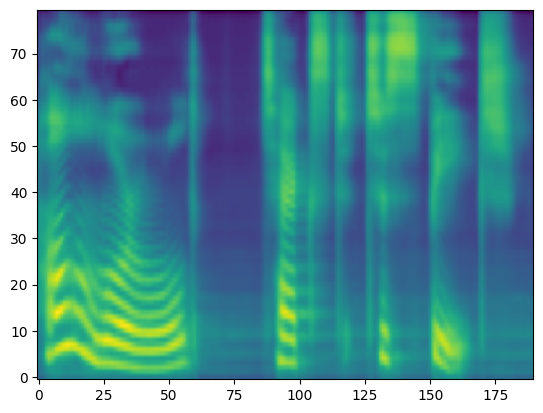

In [10]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

Note that ``Tacotron2.infer`` method perfoms multinomial sampling,
therefor, the process of generating the spectrogram incurs randomness.
Tacotron2.infer 메서드는 다항 샘플링(multinomial sampling)을 수행한다는 점에 유의하세요. 그러므로 스펙트로그램 생성 과정에는 무작위성이 포함됩니다.



torch.Size([80, 190])
torch.Size([80, 184])
torch.Size([80, 185])


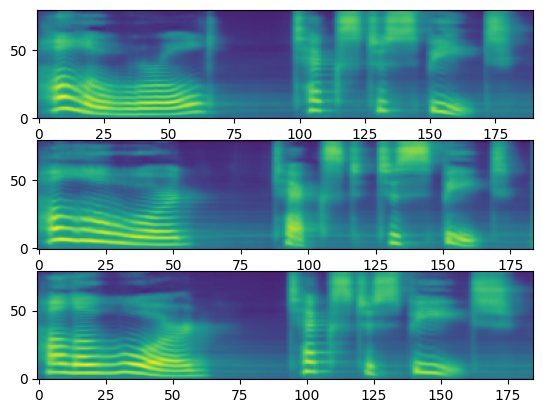

In [11]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

#추론할때마다 다른 이미지가 나온다.
plot()

## Waveform Generation

Once the spectrogram is generated, the last process is to recover the
waveform from the spectrogram.

``torchaudio`` provides vocoders based on ``GriffinLim`` and
``WaveRNN``.




### WaveRNN

Continuing from the previous section, we can instantiate the matching
WaveRNN model from the same bundle.




In [12]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
#device = "cpu"
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "I KNOCKED AT THE DOOR ON THE ANCIENT SIDE OF THE BUILDING"
text1 = "CAN I HAVE A GLASS OF FRESH ORANGE JUICE, PLEASE?"

def wavernn(text):
    with torch.inference_mode():
        processed, lengths = processor(text)
        processed = processed.to(device)
        lengths = lengths.to(device)
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        waveforms, lengths = vocoder(spec, spec_lengths)
    return waveforms, lengths

# with torch.inference_mode():
#     processed, lengths = processor(text)
#     processed = processed.to(device)
#     lengths = lengths.to(device)
#     spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
#     waveforms, lengths = vocoder(spec, spec_lengths)

waveforms, lengths = wavernn(text1)

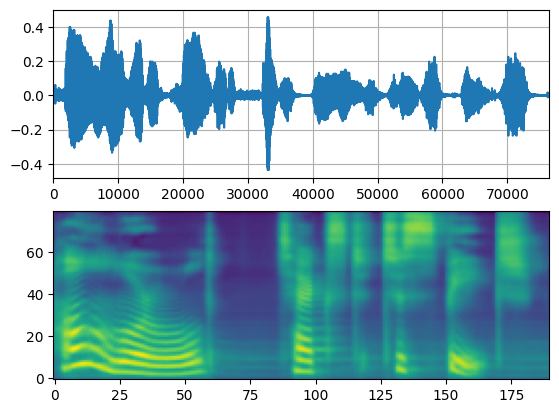

In [13]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

### Griffin-Lim

Using the Griffin-Lim vocoder is same as WaveRNN. You can instantiate
the vocode object with
:py:func:`~torchaudio.pipelines.Tacotron2TTSBundle.get_vocoder`
method and pass the spectrogram.




In [14]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

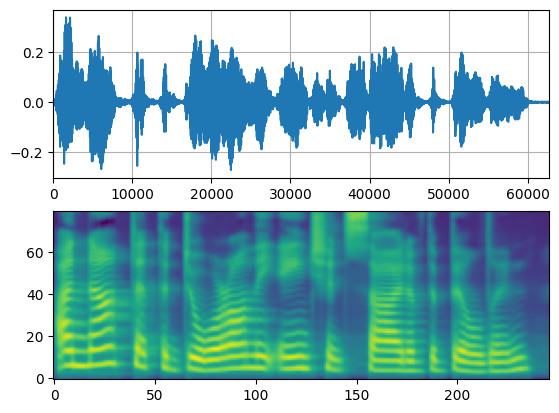

In [15]:
plot(waveforms, spec, vocoder.sample_rate)

### Waveglow

Waveglow is a vocoder published by Nvidia. The pretrained weights are
published on Torch Hub. One can instantiate the model using ``torch.hub``
module.




In [16]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

with torch.inference_mode():
    processed, lengths = processor(text1)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)


waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

Using cache found in /home/coldbrew/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/coldbrew/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/coldbrew/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/coldbrew/anaconda3/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


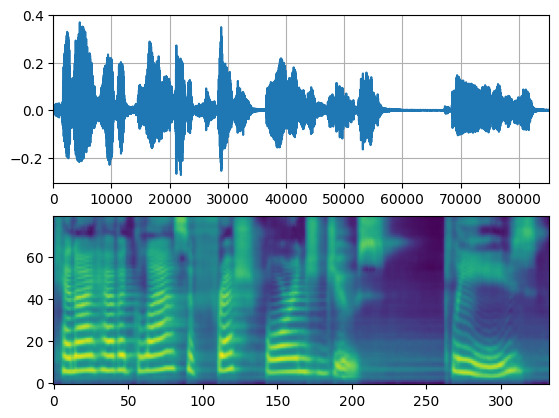

In [17]:
plot(waveforms, spec, 22050)